# Deep Learning for Cone Cells and Light Frequency

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

np.set_printoptions(suppress=True)

import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow import keras

import pickle

from simulator_lib import *
from image_lib import *

## Generating / Loading the Cone Cells

In [9]:
GENERATE_NEW_CONE_CELLS = False

NUM_EYES = 200
NUM_CELLS_PER_EYE = 1500

NUM_RED = int(NUM_CELLS_PER_EYE * PERCENT_RED)
NUM_GREEN = int(NUM_CELLS_PER_EYE * PERCENT_GREEN)
NUM_BLUE = int(NUM_CELLS_PER_EYE * PERCENT_BLUE)
assert(NUM_RED + NUM_GREEN + NUM_BLUE == NUM_CELLS_PER_EYE)

if GENERATE_NEW_CONE_CELLS:

    eyes = []

    for i in range(NUM_EYES):
        RED_MU = np.random.uniform(RED_MU_LOWER, RED_MU_UPPER)
        GREEN_MU = np.random.uniform(GREEN_MU_LOWER, GREEN_MU_UPPER)
        BLUE_MU = np.random.uniform(BLUE_MU_LOWER, BLUE_MU_UPPER)

        # create the cone cells
        cone_cells = (
            generate_cone_cells(NUM_RED, RED_MU, RED_SIGMA) +
            generate_cone_cells(NUM_GREEN, GREEN_MU, GREEN_SIGMA) +
            generate_cone_cells(NUM_BLUE, BLUE_MU, BLUE_SIGMA)
        )

        eyes.append(cone_cells)

        # save the cone cells
        with open(f"./data/normal_cone_cells/eye{i:02}.pkl", "wb") as fp:
            pickle.dump(cone_cells, fp, pickle.HIGHEST_PROTOCOL)

else:

    eyes = []

    for i in range(NUM_EYES):
        with open(f"./data/normal_cone_cells/eye{i:02}.pkl", mode="rb") as fp:
            cone_cells = pickle.load(fp)
            eyes.append(cone_cells)

## Generating the Simulation Data

In [10]:
NUM_DATA_POINTS = 15

activations = np.zeros(shape=(len(eyes) * NUM_DATA_POINTS, len(eyes[0])))
colors = np.zeros(shape=(len(eyes) * NUM_DATA_POINTS))

for i, cone_cells in enumerate(eyes):
    a, c = sample_wavelengths(
        num_data_points=NUM_DATA_POINTS, 
        cells=cone_cells, 
    )
    c = np.array(c).astype(int)

    activations[i * NUM_DATA_POINTS : (i+1) * NUM_DATA_POINTS] = a
    colors[i * NUM_DATA_POINTS : (i+1) * NUM_DATA_POINTS] = c

print(activations)
print(colors)

[[0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 1. 5. ... 1. 4. 5.]


## Feedforward Network Architecture

### Separate Data into Training and Test Sets

In [11]:
# don't shuffle the data prior to splitting, the activations are currently ordered by eyes, and we want
# to test on eyes that were never seen in the training data
PERCENT_TRAIN_SET = 0.8
NUM_TRAIN_SET = int(len(activations) * PERCENT_TRAIN_SET)

train_activations = activations[:NUM_TRAIN_SET]
train_colors = colors[:NUM_TRAIN_SET]
randomize = np.arange(len(train_activations), dtype=int)
np.random.shuffle(randomize)
train_activations = train_activations[randomize]
train_colors = train_colors[randomize]

test_activations = activations[NUM_TRAIN_SET:]
test_colors = colors[NUM_TRAIN_SET:]
randomize = np.arange(len(test_activations), dtype=int)
np.random.shuffle(randomize)
test_activations = test_activations[randomize]
test_colors = test_colors[randomize]

### Model Setup

In [12]:
UNITS = 256
model = keras.Sequential([
    keras.Input(shape=(train_activations.shape[-1], )),
    keras.layers.Dense(units=UNITS, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=UNITS, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=UNITS, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=UNITS, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=UNITS, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=UNITS, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=UNITS, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=UNITS, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=len(Color), activation="softmax"),
])

### Compile Model

In [13]:
optimizer = keras.optimizers.AdamW(learning_rate=5e-4, weight_decay=0.004)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 256)            │       384,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 846,342 (3.23 MB)

 Trainable params: 846,342 (3.23 MB)

 Non-trainable params: 0 (0.00 B)

### Fit the Model

In [14]:
EPOCHS = 20
h = model.fit(train_activations, train_colors, batch_size=64, epochs=EPOCHS, validation_split=0.1)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2828 - loss: 1.6240 - val_accuracy: 0.5875 - val_loss: 0.9932
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6313 - loss: 0.8373 - val_accuracy: 0.8417 - val_loss: 0.3973
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8578 - loss: 0.4333 - val_accuracy: 0.8708 - val_loss: 0.3235
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9150 - loss: 0.2313 - val_accuracy: 0.8750 - val_loss: 0.3068
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9267 - loss: 0.1944 - val_accuracy: 0.9125 - val_loss: 0.2971
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9376 - loss: 0.1621 - val_accuracy: 0.9125 - val_loss: 0.2556
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9469 - loss: 0.1526 - val_accuracy: 0.8958 - val_loss: 0.2707
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9532 - loss: 0.1039 - val_accuracy: 0.8917 - v

### Visualize Loss Trajectory

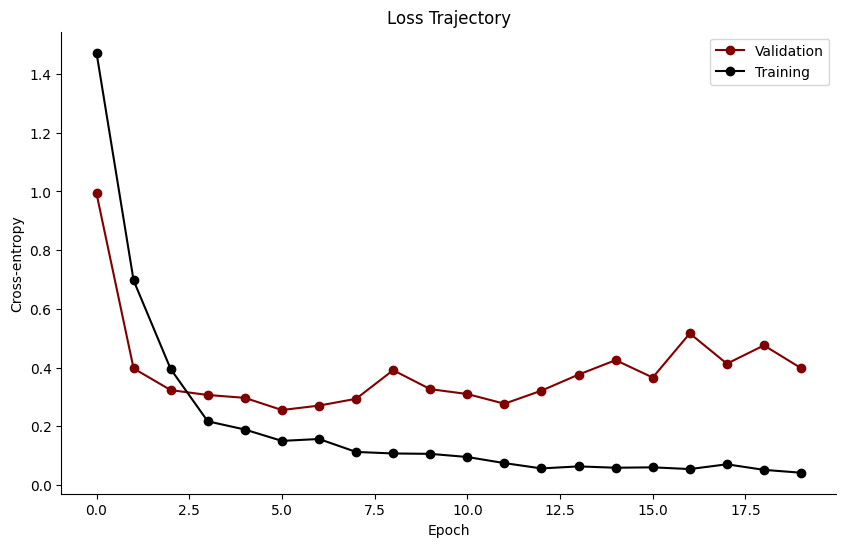

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(EPOCHS), h.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(EPOCHS), h.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

### Evaluate Model on Test Data

In [16]:
test_loss, test_accuracy = model.evaluate(test_activations, test_colors)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8907 - loss: 0.4468


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


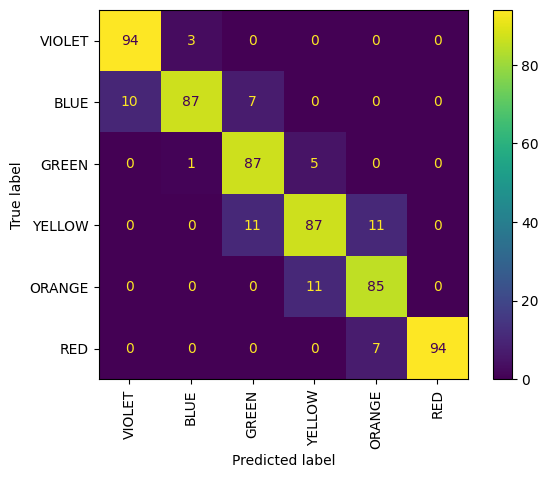

In [17]:
preds = model.predict(test_activations)

# save colors and predictions to file
array_to_image(test_colors).save("./imgs/normal/test.png")
array_to_image(preds.argmax(axis=1)).save("./imgs/normal/pred.png")

metrics.ConfusionMatrixDisplay.from_predictions(
    test_colors, 
    preds.argmax(axis=1),
    display_labels=[c.name for c in Color],
    xticks_rotation="vertical",
)

## Testing on Data from Abnormal Eyes

### "Damaged" Eyes

"Damaged" eyes have a chance for some cells to be dead and never activate.

#### Generating / Loading the Cone Cells for "Damaged" Eyes

In [18]:
GENERATE_NEW_CONE_CELLS = False

NUM_EYES = 100
PROB_DEAD_CELL_STEP = 0.01

NUM_CELLS_PER_EYE = 1500

NUM_RED = int(NUM_CELLS_PER_EYE * PERCENT_RED)
NUM_GREEN = int(NUM_CELLS_PER_EYE * PERCENT_GREEN)
NUM_BLUE = int(NUM_CELLS_PER_EYE * PERCENT_BLUE)
assert(NUM_RED + NUM_GREEN + NUM_BLUE == NUM_CELLS_PER_EYE)

if GENERATE_NEW_CONE_CELLS:

    damaged_eyes = []

    for i in range(NUM_EYES):
        RED_MU = np.random.uniform(RED_MU_LOWER, RED_MU_UPPER)
        GREEN_MU = np.random.uniform(GREEN_MU_LOWER, GREEN_MU_UPPER)
        BLUE_MU = np.random.uniform(BLUE_MU_LOWER, BLUE_MU_UPPER)
        PROB_DEAD_CELL = i * PROB_DEAD_CELL_STEP

        # create the cone cells
        cone_cells = (
            generate_cone_cells(NUM_RED, RED_MU, RED_SIGMA, PROB_DEAD_CELL) +
            generate_cone_cells(NUM_GREEN, GREEN_MU, GREEN_SIGMA, PROB_DEAD_CELL) +
            generate_cone_cells(NUM_BLUE, BLUE_MU, BLUE_SIGMA, PROB_DEAD_CELL)
        )

        damaged_eyes.append(cone_cells)

        # save the cone cells
        with open(f"./data/damaged_cone_cells/eye{i:02}.pkl", "wb") as fp:
            pickle.dump(cone_cells, fp, pickle.HIGHEST_PROTOCOL)

else:

    damaged_eyes = []

    for i in range(NUM_EYES):
        with open(f"./data/damaged_cone_cells/eye{i:02}.pkl", mode="rb") as fp:
            cone_cells = pickle.load(fp)
            damaged_eyes.append(cone_cells)

#### Testing Model on "Damaged" Eyes

In [19]:
NUM_DATA_POINTS = 200

confusion_data = []
accuracies = []

for i, cone_cells in enumerate(damaged_eyes):
    activations, colors = sample_wavelengths(
        num_data_points=NUM_DATA_POINTS, 
        cells=cone_cells, 
    )
    colors = np.array(colors).astype(int)
    preds = model.predict(activations)
    confusion_data.append((colors, preds))
    _, accuracy = model.evaluate(activations, colors)
    accuracies.append(accuracy)

    # save colors and predictions to file
    if i < 10:
        array_to_image(colors).save(f"./imgs/damaged/test{i:02}.png")
        array_to_image(preds.argmax(axis=1)).save(f"./imgs/damaged/pred{i:02}.png")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8969 - loss: 0.6822  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9051 - loss: 0.4175 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8929 - loss: 0.2967 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9002 - loss: 0.3761 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7828 - loss: 1.3040 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9307 - loss: 0.1051 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8652 - loss: 0.7291 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8946 - loss: 0.6171 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9207 - loss: 0.2719 
7/7 ━━━━━

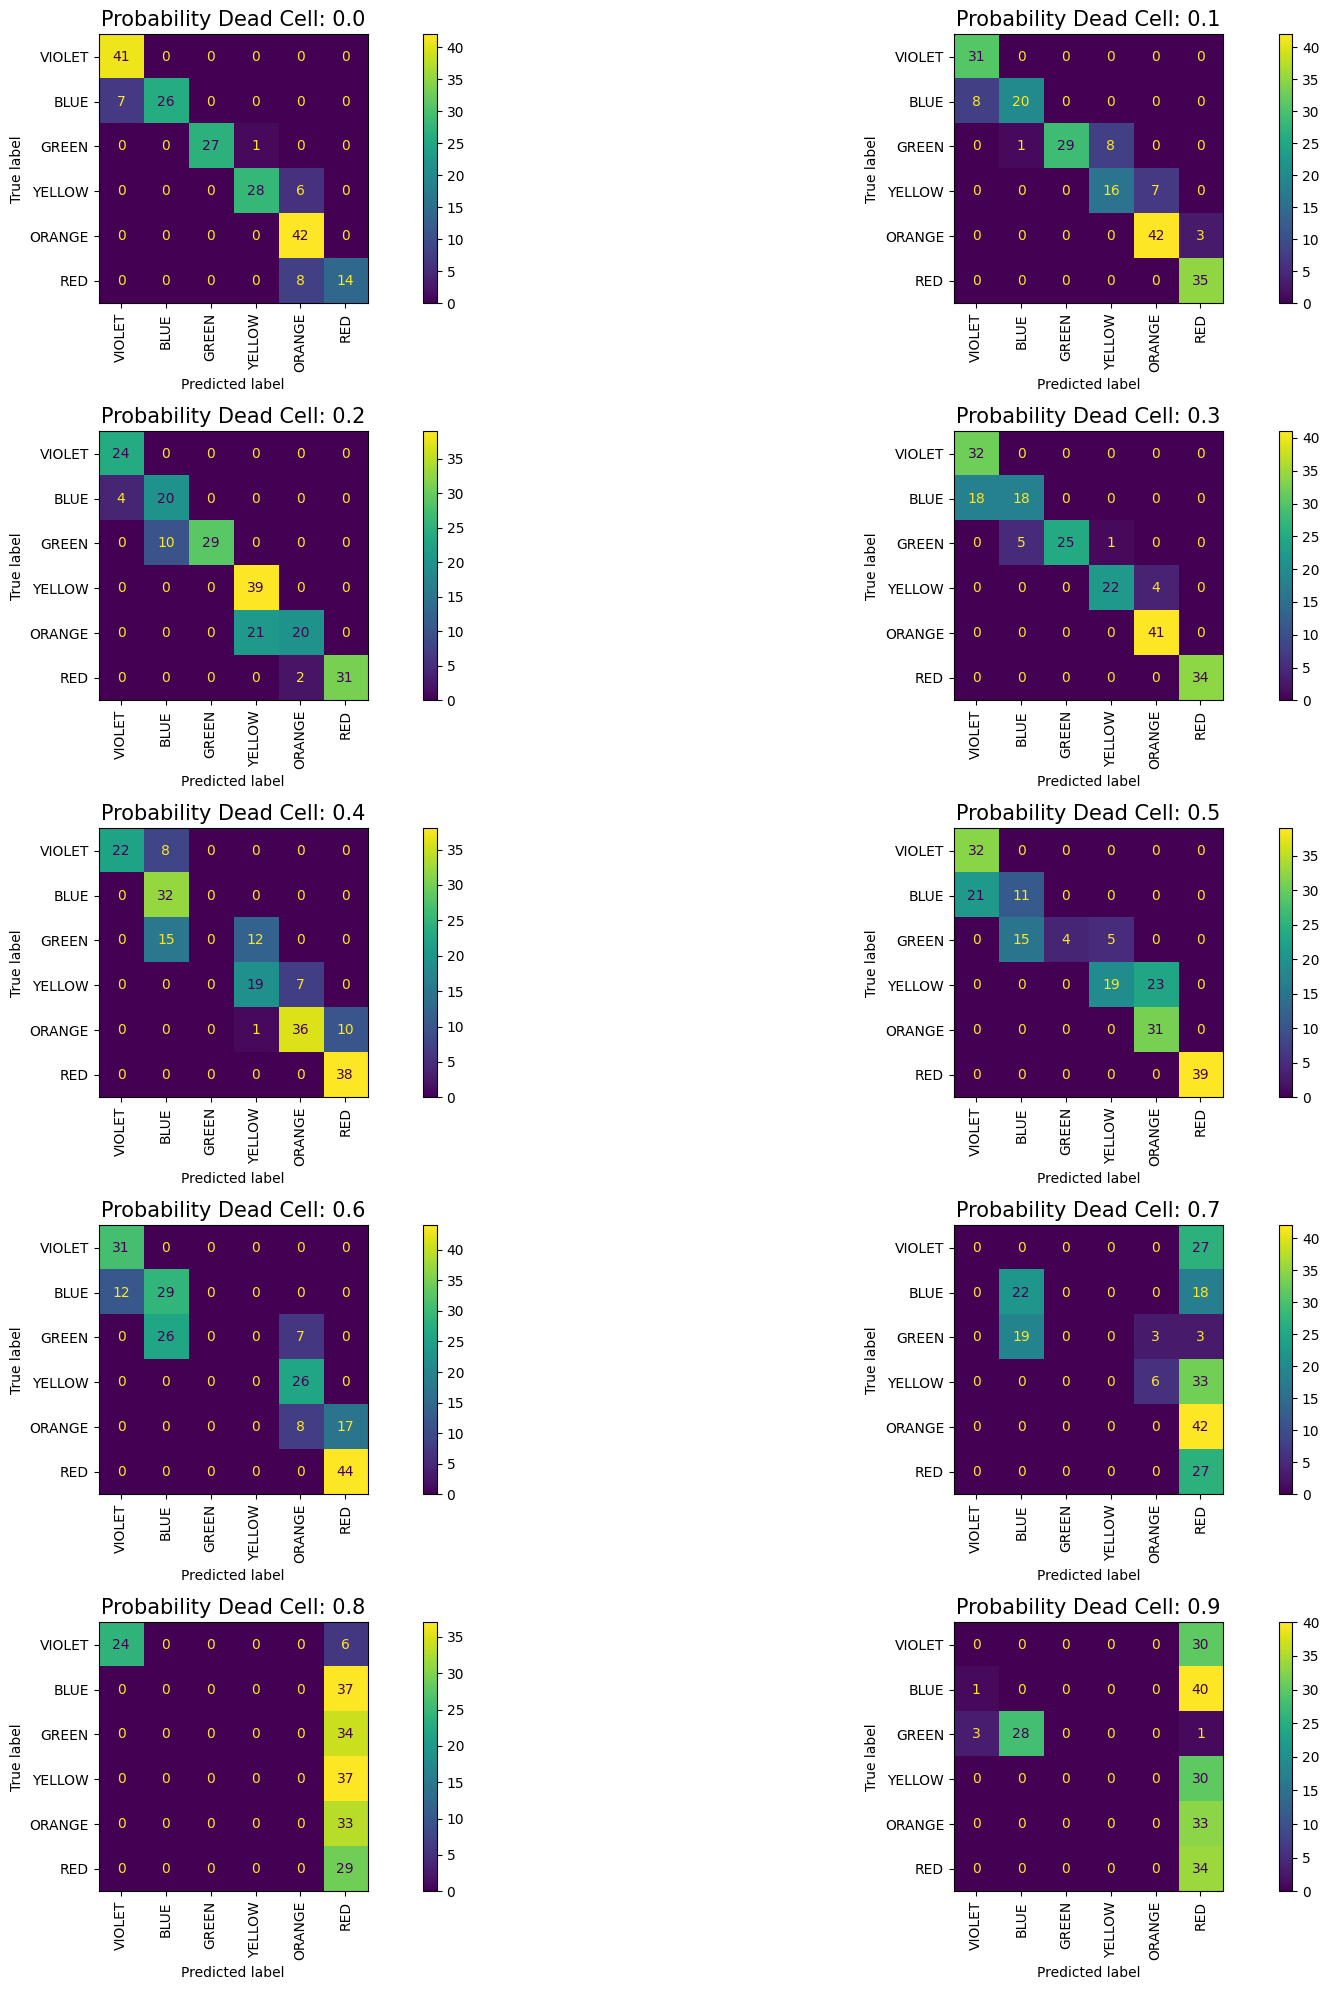

In [20]:
fig, axarr = plt.subplots(5, 2, figsize=(20,20))
for i, ax in enumerate(axarr.flat):
    colors, preds = confusion_data[i*10]
    metrics.ConfusionMatrixDisplay.from_predictions(
        colors, 
        preds.argmax(axis=1), 
        ax=ax, 
        xticks_rotation="vertical",
    )
    ax.set_title(f"Probability Dead Cell: {PROB_DEAD_CELL_STEP*i*10:0.1f}", fontsize=15)
    color_names = [c.name for c in Color]
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()
    ax.set_xticklabels([color_names[i] for i in xticks])
    ax.set_yticklabels([color_names[i] for i in yticks])
fig.tight_layout()

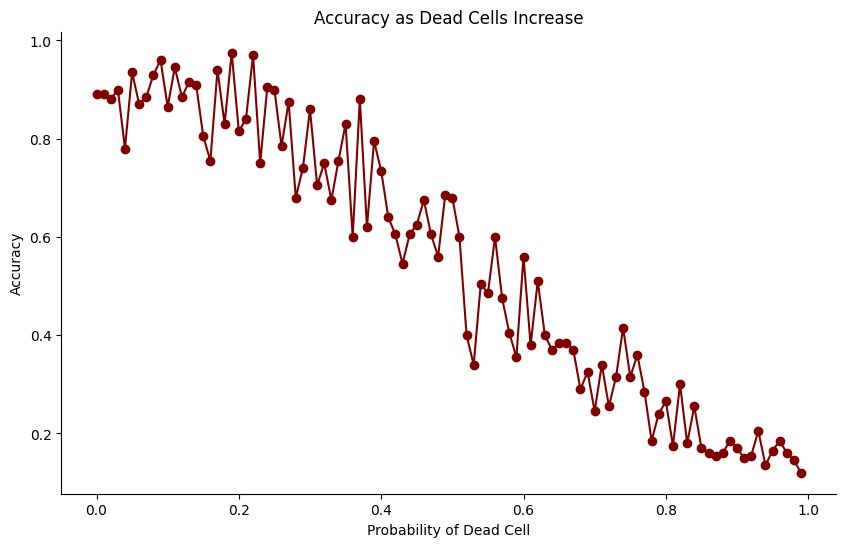

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot([PROB_DEAD_CELL_STEP * i for i in range(NUM_EYES)], accuracies, 'o-', color='maroon')
ax.set_xlabel('Probability of Dead Cell')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy as Dead Cells Increase')
sns.despine(ax=ax)

### Colorblind Eyes

Specifically red-green colorblindness

#### Generating / Loading the Cone Cells for Colorblind Eyes

In [22]:
GENERATE_NEW_CONE_CELLS = False

NUM_EYES = 40
NUM_CELLS_PER_EYE = 1500

NUM_RED_GREEN = int(NUM_CELLS_PER_EYE * PERCENT_RED) + int(NUM_CELLS_PER_EYE * PERCENT_GREEN)
NUM_BLUE = int(NUM_CELLS_PER_EYE * PERCENT_BLUE)
assert(NUM_RED_GREEN + NUM_BLUE == NUM_CELLS_PER_EYE)

if GENERATE_NEW_CONE_CELLS:

    colorblind_eyes = []

    for i in range(NUM_EYES):
        BLUE_MU = np.random.uniform(BLUE_MU_LOWER, BLUE_MU_UPPER)
    
        # create the cone cells
        cone_cells = (
            generate_cone_cells(NUM_RED_GREEN, RED_GREEN_MU, RED_GREEN_SIGMA) +
            generate_cone_cells(NUM_BLUE, BLUE_MU, BLUE_SIGMA)
        )

        colorblind_eyes.append(cone_cells)

        # save the cone cells
        with open(f"./data/colorblind_cone_cells/eye{i:02}.pkl", "wb") as fp:
            pickle.dump(cone_cells, fp, pickle.HIGHEST_PROTOCOL)

else:

    colorblind_eyes = []

    for i in range(NUM_EYES):
        with open(f"./data/colorblind_cone_cells/eye{i:02}.pkl", mode="rb") as fp:
            cone_cells = pickle.load(fp)
            colorblind_eyes.append(cone_cells)

#### Testing Model on Colorblind Eyes

In [23]:
NUM_DATA_POINTS = 100

confusion_data = []

for i, cone_cells in enumerate(colorblind_eyes):
    activations, colors = sample_wavelengths(
        num_data_points=NUM_DATA_POINTS, 
        cells=cone_cells, 
    )
    colors = np.array(colors).astype(int)
    preds = model.predict(activations)
    confusion_data.append((colors, preds))
    model.evaluate(activations, colors)

    # save colors and predictions to file
    if i < 10:
        array_to_image(colors).save(f"./imgs/colorblind/test{i:02}.png")
        array_to_image(preds.argmax(axis=1)).save(f"./imgs/colorblind/pred{i:02}.png")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4736 - loss: 3.7072 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4988 - loss: 4.1083 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4067 - loss: 3.6644 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6496 - loss: 1.5908 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5363 - loss: 2.9486 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4180 - loss: 4.3289 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5766 - loss: 4.6769 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5664 - loss: 1.8923 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5354 - loss: 2.3341
4/4 ━━━━━━

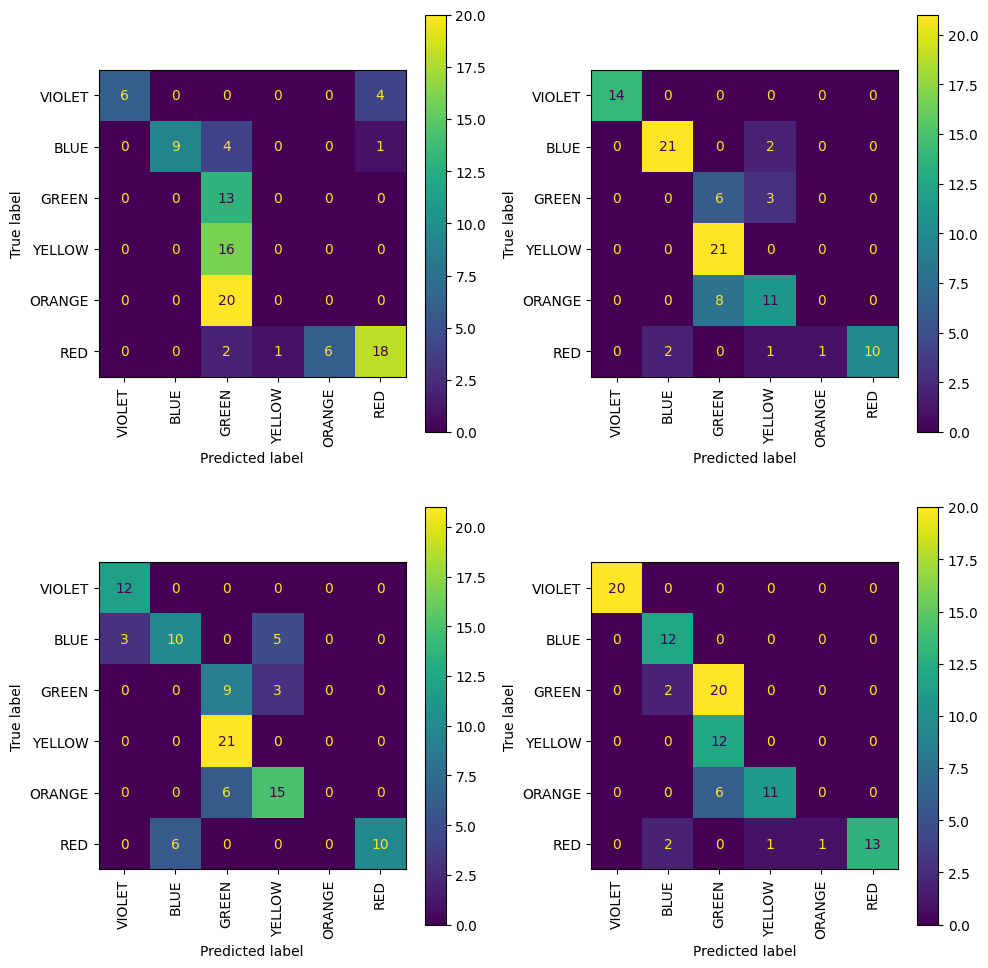

In [24]:
fig, axarr = plt.subplots(2, 2, figsize=(10,10))
for i, ax in enumerate(axarr.flat):
    colors, preds = confusion_data[i]
    metrics.ConfusionMatrixDisplay.from_predictions(
        colors, 
        preds.argmax(axis=1), 
        ax=ax,
        xticks_rotation="vertical",
    )
    color_names = [c.name for c in Color]
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()
    ax.set_xticklabels([color_names[i] for i in xticks])
    ax.set_yticklabels([color_names[i] for i in yticks])
fig.tight_layout()

### Tetrachromatic Eyes

Tetrachromatic eyes have a fourth type of cell that detects wavelengths between what is detected by the normal red and green cone cells

#### Generating / Loading the Cone Cells for Tetrachromatic Eyes

In [25]:
GENERATE_NEW_CONE_CELLS = False

NUM_EYES = 50
NUM_CELLS_PER_EYE = 1500

NUM_RED = int(NUM_CELLS_PER_EYE * TETRA_RED)
NUM_TETRA = int(NUM_CELLS_PER_EYE * TETRA_PRIME)
NUM_GREEN = int(NUM_CELLS_PER_EYE * TETRA_GREEN)
NUM_BLUE = int(NUM_CELLS_PER_EYE * TETRA_BLUE)
if not (NUM_RED + NUM_TETRA + NUM_GREEN + NUM_BLUE == NUM_CELLS_PER_EYE):
    NUM_RED += 1
assert(NUM_RED + NUM_TETRA + NUM_GREEN + NUM_BLUE == NUM_CELLS_PER_EYE)

if GENERATE_NEW_CONE_CELLS:

    tetrachromatic_eyes = []

    for i in range(NUM_EYES):
        RED_MU = np.random.uniform(RED_MU_LOWER, RED_MU_UPPER)
        TETRA_MU = np.random.uniform(TETRA_MU_LOWER, TETRA_MU_UPPER)
        GREEN_MU = np.random.uniform(GREEN_MU_LOWER, GREEN_MU_UPPER)
        BLUE_MU = np.random.uniform(BLUE_MU_LOWER, BLUE_MU_UPPER)
    
        # create the cone cells
        cone_cells = (
            generate_cone_cells(NUM_RED, RED_MU, RED_SIGMA) +
            generate_cone_cells(NUM_TETRA, TETRA_MU, TETRA_SIGMA) +
            generate_cone_cells(NUM_GREEN, GREEN_MU, GREEN_SIGMA) +
            generate_cone_cells(NUM_BLUE, BLUE_MU, BLUE_SIGMA)
        )

        tetrachromatic_eyes.append(cone_cells)

        # save the cone cells
        with open(f"./data/tetrachromatic_cone_cells/eye{i:02}.pkl", "wb") as fp:
            pickle.dump(cone_cells, fp, pickle.HIGHEST_PROTOCOL)

else:

    tetrachromatic_eyes = []

    for i in range(NUM_EYES):
        with open(f"./data/tetrachromatic_cone_cells/eye{i:02}.pkl", mode="rb") as fp:
            cone_cells = pickle.load(fp)
            tetrachromatic_eyes.append(cone_cells)

#### Testing Model on Tetrachromatic Eyes

In [26]:
NUM_DATA_POINTS = 100

confusion_data = []

for i, cone_cells in enumerate(tetrachromatic_eyes):
    activations, colors = sample_wavelengths(
        num_data_points=NUM_DATA_POINTS, 
        cells=cone_cells, 
    )
    colors = np.array(colors).astype(int)
    preds = model.predict(activations)
    confusion_data.append((colors, preds))
    model.evaluate(activations, colors)

    # save colors and predictions to file
    if i < 10:
        array_to_image(colors).save(f"./imgs/tetrachromatic/test{i:02}.png")
        array_to_image(preds.argmax(axis=1)).save(f"./imgs/tetrachromatic/pred{i:02}.png")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5962 - loss: 2.0179 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9182 - loss: 0.2981 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8306 - loss: 0.6482 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8742 - loss: 0.4968 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8638 - loss: 0.7651 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7533 - loss: 1.8658 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8023 - loss: 0.9845 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7445 - loss: 0.7072 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8330 - loss: 0.4210 
4/4 ━━━━━━

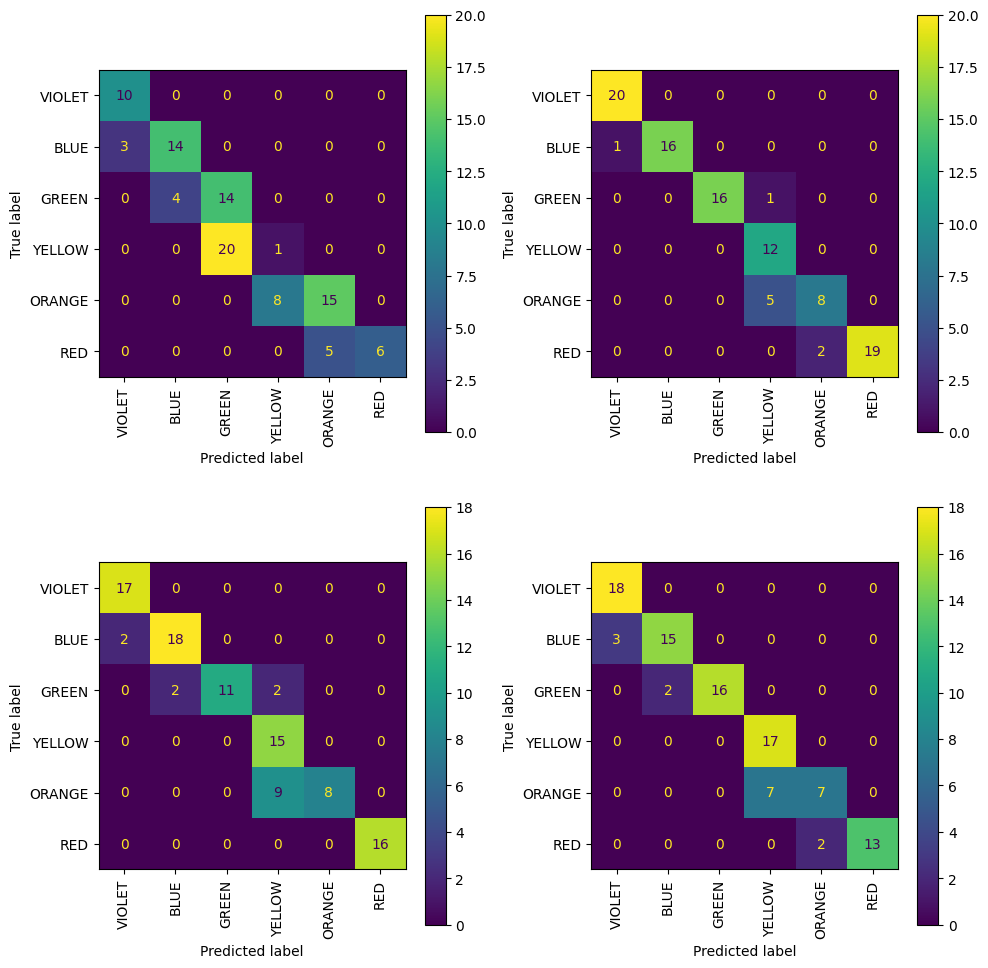

In [27]:
fig, axarr = plt.subplots(2, 2, figsize=(10,10))
for i, ax in enumerate(axarr.flat):
    colors, preds = confusion_data[i]
    metrics.ConfusionMatrixDisplay.from_predictions(
        colors, 
        preds.argmax(axis=1), 
        ax=ax,
        xticks_rotation="vertical",
    )
    color_names = [c.name for c in Color]
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()
    ax.set_xticklabels([color_names[i] for i in xticks])
    ax.set_yticklabels([color_names[i] for i in yticks])
fig.tight_layout()

## Testing on Picture of Flower

In [46]:
flower_wavelengths = [
    value
    for row in FLOWER
    for value in list(map(lambda x: np.random.uniform(x.value["min"], x.value["max"]), row))
]
flower_values = np.array([
    value
    for row in FLOWER
    for value in list(map(lambda x: x.value["val"], row))
])

In [42]:
def flower_values_to_image(values: np.array):
    """
    Creates image of the flower using values

    :param values: numpy array of ints corresponding to Color enums
    :return: Image from colors
    """

    rows = cols = 300

    pixels = np.zeros(shape=(300, 300, 3), dtype=np.uint8)
    for ind, value in enumerate(values):
        pixel = color_to_rgb(value)
        x = int(ind / 10) * 30
        y = int(ind % 10) * 30
        for i in range(30):
            for j in range(30):
                pixels[x + i][y + j] = pixel
    return Image.fromarray(pixels)


### Original Flower

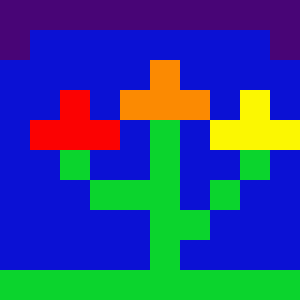

In [43]:
flower_values_to_image(flower_values)

### Feeding through Normal Eye

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


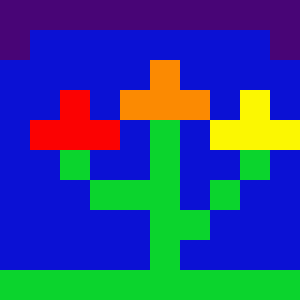

In [51]:
cells = eyes[0]
data = np.zeros(shape=(100, len(cells)))
for i, wavelength in enumerate(flower_wavelengths):
    data[i] = get_cell_responses(cells, wavelength)

preds = model.predict(data)

flower_values_to_image(preds.argmax(axis=1))

### Feeding through 25% Dead Eye

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


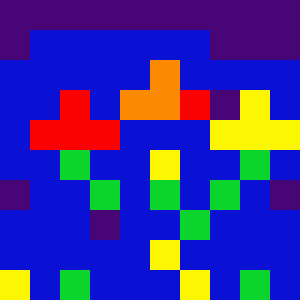

In [53]:
cells = damaged_eyes[len(damaged_eyes) // 4]
data = np.zeros(shape=(100, len(cells)))
for i, wavelength in enumerate(flower_wavelengths):
    data[i] = get_cell_responses(cells, wavelength)

preds = model.predict(data)

flower_values_to_image(preds.argmax(axis=1))

### Feeding through 50% Damaged Eye

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


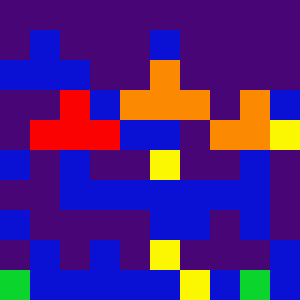

In [54]:
cells = damaged_eyes[len(damaged_eyes) // 2]
data = np.zeros(shape=(100, len(cells)))
for i, wavelength in enumerate(flower_wavelengths):
    data[i] = get_cell_responses(cells, wavelength)

preds = model.predict(data)

flower_values_to_image(preds.argmax(axis=1))

#### Feeding through 75% Damaged Eye

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


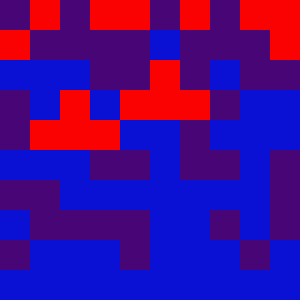

In [55]:
cells = damaged_eyes[3 * len(damaged_eyes) // 4]
data = np.zeros(shape=(100, len(cells)))
for i, wavelength in enumerate(flower_wavelengths):
    data[i] = get_cell_responses(cells, wavelength)

preds = model.predict(data)

flower_values_to_image(preds.argmax(axis=1))

#### Feeding through Colorblind Eye

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


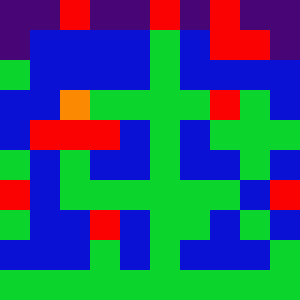

In [56]:
cells = colorblind_eyes[0]
data = np.zeros(shape=(100, len(cells)))
for i, wavelength in enumerate(flower_wavelengths):
    data[i] = get_cell_responses(cells, wavelength)

preds = model.predict(data)

flower_values_to_image(preds.argmax(axis=1))

#### Feeding through Tetrachromatic Eye

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


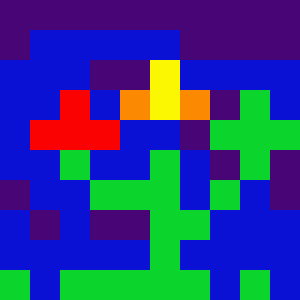

In [57]:
cells = tetrachromatic_eyes[0]
data = np.zeros(shape=(100, len(cells)))
for i, wavelength in enumerate(flower_wavelengths):
    data[i] = get_cell_responses(cells, wavelength)

preds = model.predict(data)

flower_values_to_image(preds.argmax(axis=1))